## Module Import

In [1]:
# import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms

import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np

### Google Drive Mount

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Unzip dataset

In [3]:
# unzip train, valid dataset
# target 을 정하지 않으면 google drive 내의 content 드라이브에 위치시킴
# 런타임을 다시 시작할 때 마다 unzip 을 새로 해주어야 함.
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_train.zip
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_val.zip
# !unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_test.zip

Archive:  /content/gdrive/MyDrive/Project_dataset/Font_npy_100_train.zip
replace __MACOSX/._Font_npy_100_train? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/gdrive/MyDrive/Project_dataset/Font_npy_100_val.zip
replace __MACOSX/._Font_npy_100_val? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Chack Data and set dataloader (custom)

In [4]:
import glob
class MyDataset(Dataset) :
    def __init__(self, npy_dir) :
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        self.npy_path = glob.glob(os.path.join(npy_dir, '*', '*.npy'))

    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = data[0]
        image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)

train_data = MyDataset("/content/Font_npy_100_train") # unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
valid_data = MyDataset("/content/Font_npy_100_val")
#test_data = MyDataset("/content/Font_npy_90_test")

print(len(train_data))
print(len(valid_data))
#print(len(test_data))

37232
7800


In [5]:
# define dataloader
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)

# check dataloader
image,label = next(iter(valid_loader))
print(image.shape)
print(label.shape)

torch.Size([50, 1, 100, 100])
torch.Size([50])


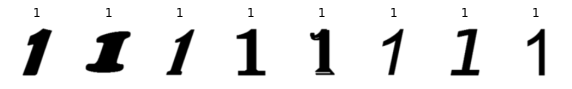

In [6]:
# visualize data
# character - encoded_label dict , 데이터 확인해보고 싶을 때 참조
label_dict = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17,
'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'P': 24, 'Q': 25, 
'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 
'Z': 34, 'a': 35, 'b': 36, 'd': 37, 'e': 38, 'f': 39, 'g': 40, 'h': 41, 
'i': 42, 'j': 43, 'm': 44, 'n': 45, 'o': 46, 'q': 47, 'r': 48, 't': 49, 'u': 50, 'y': 51}

# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+1200][0].squeeze(), cmap = "gray")
    plt.title(dataset[i+1200][1])
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

image_show(train_data, 8)

In [7]:
len(label_dict)

52

## Training environment

### check GPU configuration

In [8]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Sun Dec 18 10:18:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Fix Seed

In [62]:
# FIX SEED
def fix_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

fix_seed(42)
np.random.seed(42)

## Model Tuning

In [69]:
input_size = 100
num_classes = 52
learning_rate = 0.001

class CNN(nn.Module) :
    def __init__(self, input_size, num_classes) :
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,# 16 * 50*50
                      out_channels = 16,
                      kernel_size = 5,
                      stride = 2,
                      padding = 2),
            nn.BatchNorm2d(num_features = 16),
            nn.SiLU()
        )
        
        self.layer2 = nn.Sequential( # 32 * 48*48
            nn.Conv2d(in_channels = 16,
                      out_channels = 32,
                      kernel_size = 5,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 32),
            nn.SiLU()
        )
        
        self.layer3 = nn.Sequential( # 64*24*24
            nn.Conv2d(in_channels = 32,
                      out_channels = 64,
                      kernel_size = 5,
                      stride = 2, 
                      padding = 2),
            nn.BatchNorm2d(num_features = 64),
            nn.SiLU()
        )

        self.layer4 = nn.Sequential( # 128*24*24
            nn.Conv2d(in_channels = 64,
                      out_channels = 128,
                      kernel_size = 5,
                      stride = 1, 
                      padding = 2),
            nn.BatchNorm2d(num_features = 128),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size = 2) # 128*12*12
        )

        self.layer5 = nn.Sequential( # 256*12*12
            nn.Conv2d(in_channels = 128,
                      out_channels = 256,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 256),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size = 2) # 256*6*6
        )

        self.layer6 = nn.Sequential( # 256*6*6
            nn.Conv2d(in_channels = 256,
                      out_channels = 256,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 256),
            nn.SiLU()
        )
        self.layer7 = nn.Sequential( # 256*6*6
            nn.Conv2d(in_channels = 256,
                      out_channels = 256,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 256),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size = 2) # 256*3*3
        )
        
        self.fc1 = nn.Linear(in_features = 256*3*3, out_features = 256)
        self.fc2 = nn.Linear(in_features = 256, out_features = 96)
        self.fc3 = nn.Linear(in_features = 96, out_features = num_classes) 
    
    def forward(self, x) :
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = F.silu(x)
        x = x.reshape(x.size(0), -1)
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x)
        return x

model = CNN(input_size, num_classes)

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [71]:

import time
num_epochs = 20

# Train Loop
tr_loss = []
tr_acc = []

from tqdm import tqdm

start = time.time()
best_valid_loss = torch.inf
best_epoch = 0
model = model.to(device)
epochloop = tqdm(range(num_epochs), position=0, desc='Training', leave=True)
for epoch in epochloop:
    model.train()
    train_loss = 0
    train_acc = 0

    ## Train
    for idx, (image, label) in enumerate(train_loader):
        epochloop.set_postfix_str(f'Training batch {idx}/{len(train_loader)}') # visualize
        image, label = image.to(device), label.to(device)

        out = model(image).squeeze(1)
        # acc
        _, pred = torch.max(out.data, 1)

        train_acc += (pred == label).sum()

        # loss
        optimizer.zero_grad()
        loss = criterion(out.squeeze(), label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()   

    # print epoch loss & accuracy
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_data) * 100}%')
    tr_loss.append(train_loss / len(train_loader))
    tr_acc.append(train_acc.cpu().numpy() / len(train_data) * 100)

end = time.time()
duration = end - start
print("Training takes {:.2f}minutes".format(duration/60))

Training:   5%|▌         | 1/20 [00:24<07:32, 23.83s/it, Training batch 5/745]

Epoch 1/20 | Train Loss: 0.482 Train Acc: 87.75515747070312%


Training:  10%|█         | 2/20 [00:47<07:08, 23.78s/it, Training batch 5/745]

Epoch 2/20 | Train Loss: 0.191 Train Acc: 94.6255874633789%


Training:  15%|█▌        | 3/20 [01:11<06:44, 23.78s/it, Training batch 5/745]

Epoch 3/20 | Train Loss: 0.137 Train Acc: 95.887939453125%


Training:  20%|██        | 4/20 [01:35<06:21, 23.85s/it, Training batch 5/745]

Epoch 4/20 | Train Loss: 0.113 Train Acc: 96.33648681640625%


Training:  25%|██▌       | 5/20 [01:59<05:58, 23.93s/it, Training batch 5/745]

Epoch 5/20 | Train Loss: 0.099 Train Acc: 96.76353454589844%


Training:  30%|███       | 6/20 [02:23<05:33, 23.81s/it, Training batch 5/745]

Epoch 6/20 | Train Loss: 0.085 Train Acc: 97.13418579101562%


Training:  35%|███▌      | 7/20 [02:46<05:09, 23.80s/it, Training batch 5/745]

Epoch 7/20 | Train Loss: 0.076 Train Acc: 97.43231201171875%


Training:  40%|████      | 8/20 [03:10<04:44, 23.68s/it, Training batch 5/745]

Epoch 8/20 | Train Loss: 0.071 Train Acc: 97.48603057861328%


Training:  45%|████▌     | 9/20 [03:34<04:20, 23.68s/it, Training batch 5/745]

Epoch 9/20 | Train Loss: 0.069 Train Acc: 97.60420989990234%


Training:  50%|█████     | 10/20 [03:57<03:55, 23.59s/it, Training batch 5/745]

Epoch 10/20 | Train Loss: 0.066 Train Acc: 97.62032318115234%


Training:  55%|█████▌    | 11/20 [04:20<03:31, 23.52s/it, Training batch 5/745]

Epoch 11/20 | Train Loss: 0.060 Train Acc: 97.7761001586914%


Training:  60%|██████    | 12/20 [04:44<03:07, 23.45s/it, Training batch 5/745]

Epoch 12/20 | Train Loss: 0.057 Train Acc: 97.82444763183594%


Training:  65%|██████▌   | 13/20 [05:07<02:43, 23.43s/it, Training batch 5/745]

Epoch 13/20 | Train Loss: 0.055 Train Acc: 97.9560546875%


Training:  70%|███████   | 14/20 [05:30<02:20, 23.43s/it, Training batch 5/745]

Epoch 14/20 | Train Loss: 0.045 Train Acc: 98.1440658569336%


Training:  75%|███████▌  | 15/20 [05:54<01:57, 23.42s/it, Training batch 5/745]

Epoch 15/20 | Train Loss: 0.048 Train Acc: 98.10914611816406%


Training:  80%|████████  | 16/20 [06:18<01:34, 23.57s/it, Training batch 5/745]

Epoch 16/20 | Train Loss: 0.051 Train Acc: 97.99365997314453%


Training:  85%|████████▌ | 17/20 [06:41<01:10, 23.63s/it, Training batch 5/745]

Epoch 17/20 | Train Loss: 0.044 Train Acc: 98.1655502319336%


Training:  90%|█████████ | 18/20 [07:05<00:47, 23.67s/it, Training batch 5/745]

Epoch 18/20 | Train Loss: 0.046 Train Acc: 98.1225814819336%


Training:  95%|█████████▌| 19/20 [07:29<00:23, 23.73s/it, Training batch 5/745]

Epoch 19/20 | Train Loss: 0.046 Train Acc: 98.1413803100586%


Training: 100%|██████████| 20/20 [07:53<00:00, 23.66s/it, Training batch 744/745]

Epoch 20/20 | Train Loss: 0.042 Train Acc: 98.27030181884766%
Training takes 7.89minutes


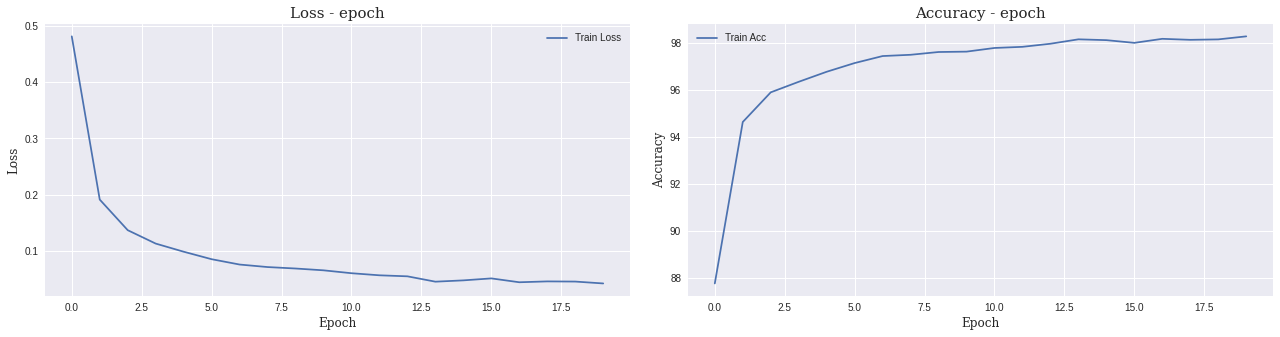

In [72]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(22, 5))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()
axs[0].plot(range(num_epochs), tr_loss, label="Train Loss")
axs[0].legend()
axs[0].set_title("Loss - epoch", fontsize= 15, fontfamily = 'Serif')
axs[0].set_xlabel('Epoch', fontsize= 12, fontfamily = 'Serif')
axs[0].set_ylabel('Loss', fontsize= 12, fontfamily = 'Serif')
axs[1].plot(range(num_epochs), tr_acc, label="Train Acc")
axs[1].legend()
axs[1].set_title("Accuracy - epoch", fontsize= 15, fontfamily = 'Serif')
axs[1].set_xlabel('Epoch', fontsize= 12, fontfamily = 'Serif')
axs[1].set_ylabel('Accuracy', fontsize= 12, fontfamily = 'Serif')
plt.show()

In [73]:
test_model = CNN(input_size, num_classes).to(device)

torch.save(model.state_dict(), "20180594.pth")

test_model.load_state_dict(torch.load('20180594.pth'))
acc_list = []
test_model.eval()

# metrics
test_acc = 0
with torch.no_grad():
    for image, label in valid_loader:
        image, label = image.to(device), label.to(device)

        # forward pass
        out = test_model(image)

        # acc
        _, pred = torch.max(out, 1)
        test_acc += (pred==label).sum()
        
    print(f'Accuracy: {test_acc.cpu().numpy()/len(valid_data) * 100}%')

Accuracy: 96.91025641025641%
